In [9]:
import polars as pl
import polars.selectors as cs
import pynsee
from pynsee.download import download_file
import plotnine as p9

In [ ]:

url = "https://koumoul.com/s/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/convert"
emissions = pl.read_csv(url, schema_overrides={'INSEE commune':pl.String()})
secteurs = emissions.select(cs.by_dtype(pl.Float64)).columns
emissions = emissions.with_columns(
    dep=pl.col('INSEE commune').str.head(2)
)


In [ ]:

filosofi = pl.DataFrame(download_file("FILOSOFI_COM_2016"))
filosofi = filosofi.with_columns(
    cs.exclude("CODGEO", "LIBGEO").cast(pl.Float64),
    dep=pl.col('CODGEO').str.head(2)
)

In [5]:

communes = pl.DataFrame(download_file("COG_COMMUNE_2022"))
(
    communes \
        .filter(pl.col('TYPECOM') == 'COM')
        .select('COM', 'DEP', 'REG')
        .unique()
        .group_by('DEP')
        .len(name='nunique')
        .sort('nunique', descending=True)
)



DEP,nunique
str,u32
"""62""",890
"""02""",799
"""80""",772
"""57""",725
"""76""",708
…,…
"""971""",32
"""974""",24
"""973""",22


In [6]:
# Calculer nb personnes par menage fiscal totales 
filosofi.select(pl.sum('NBPERSMENFISC16')*1e-6)

NBPERSMENFISC16
f64
66.932242


In [13]:

# Calculer les émissions totales du secteur “Résidentiel” par département
# et rapporter la valeur au département le plus polluant dans le domaine
# En tirer des intutitions sur la réalité que cette statistique reflèt

res = (
    emissions
    .group_by('dep')
    .agg(pl.sum('Résidentiel'))
    .with_columns(
        (pl.col("Résidentiel")/pl.max('Résidentiel')).alias('Résidentiel_ind')
    )
    .join(
        filosofi \
            .group_by('dep')
            .agg(pl.sum('NBPERSMENFISC16'))
            .with_columns(
                (pl.col("NBPERSMENFISC16")/pl.max('NBPERSMENFISC16')).alias('NBPERSMENFISC16_ind')
                ), 
        on='dep'
    )
)


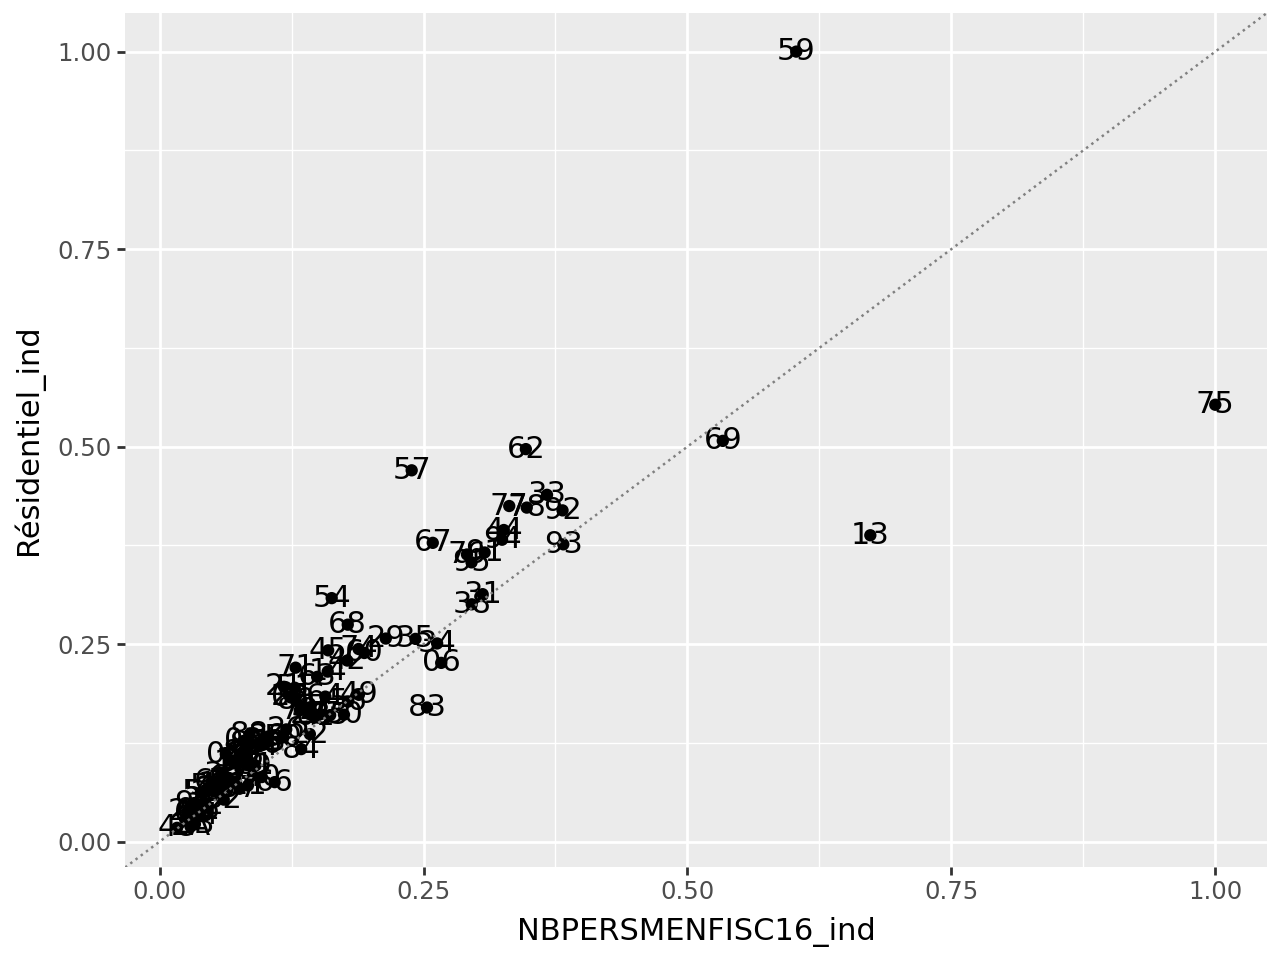

In [16]:
g = (
    p9.ggplot(res)
    + p9.aes(x='NBPERSMENFISC16_ind', y='Résidentiel_ind', label='dep')
    + p9.geom_point()
    + p9.geom_text()
    + p9.geom_abline(
        intercept=0,
        slope=1, 
        color='grey',
        linetype='dotted'
    )
)

g